We'll start by using the [markovify](https://github.com/jsvine/markovify/) library to make some social-media-sized utterances in the style of Jane Austen.  This will be the basis for generating a synthetic social media stream.

In [79]:
import pandas as pd

df = pd.read_csv('response.csv') 
df = df.fillna('')
df['response']=df.iloc[:,3]+df.iloc[:,5]+df.iloc[:,6]
df['issue'] = df.iloc[:,1]
df['symptom'] = df.iloc[:,2] + df.iloc[:,4]
subset = df.iloc[:,-3:]

In [92]:
import markovify
import codecs

model = markovify.NewlineText(subset.response, retain_original=False, state_size=3)

for i in range(10):
    print(model.make_short_sentence(200))

Starter makes clicking noise, won't start the engine unless you hit the starter with a hammer.
I turn the wheel. 
The car is very slow to get moving and there's a horrible grinding noise as I drive.
Car doesn't always start when it's low on blinker fluid
I turn the radio and a/c off, trying to use as little power as possible, and the batteries just keep dying after about a week. Aaarrrggghhh!!!!
Steering wheel shakes when running at speed
the privacy glass between my driver and my seating area doesn't work well. sometimes, it won't go up at all!
Exhaust has a lot of black smoke and acrid smell.
Customer states breaks make a terrible sound when stopping. 
It won't start and doesn't respond when trying to jump start it.


In [93]:
def train_markov_type(data, issue):
    return markovify.Text(data[data["issue"] == issue].response, retain_original=False, state_size=3)

other_model = train_markov_type(subset, "Other")
brakes_model = train_markov_type(subset, "Brakes")
starter_model = train_markov_type(subset, "Starter")

In [94]:
make_sentence(other_model)

'Rear right tail light is out.'

In [95]:
make_sentence(brakes_model)

'If I pump the brake it works better.'

In [96]:
make_sentence(starter_model)

"I tried starting my car but it doesn't work."

We can combine these models with relative weights, but this yields somewhat unusual results:

In [98]:
compound_model = markovify.combine([other_model, brakes_model, starter_model], [14, 3, 3])

In [100]:
for i in range(20):
    print(make_sentence(compound_model))

Leak of a clear, cloudy, oil like substance in the back of the car.
The gas door won't open.
There a loud knocking sound coming from the front of the car.
The air conditioner only blows cold sometimes.
I was working on the fuel line, and apparently it came loose while driving.
The car won't turn on, but it won't turn off either.
AC doesn't work
super frustrating every time I start it
I can't put gas in my car if the door won't open, and I'm all out of gas.
The windshield has a growing crack in it.
When I put the car in reverse, the hatchback latch opens so that the backup camera can engage.
Steering wheel shakes when running at speed
The left rear window only rolls down but does not roll back up.
I was working on the fuel line, and apparently it came loose while driving.
It won't go, but it kind of won't stop either.
That's all good.
This is the third one, and I don't get it.
Aaarrrggghhh!!!!
the flux capacitor is misfiring and I can't get up to 88 MPH
I was working on the fuel line, a

As is more or less the case in the real world, we'll assume that a small percentage of users are responsible for the bulk of social media activity, and that the bulk of users are responsible for relatively few posts.  We'll model this with a table of random user IDs that has a collection of relatively few talkative users and relatively many moderate users; the proportion of utterances from talkative users to utterances from moderate users is the inverse of the proportion of talkative users to moderate users.

In [101]:
import numpy
import math
import collections

class UserTable(object):
    def __init__(self, size, weights=[8, 2]):
        self._talkative = collections.deque()
        self._moderate = collections.deque()
        self._size = size
        self._cutoff = float(weights[0]) / sum(weights)
        
        for i in range(size):
            new_uid = math.floor(numpy.random.uniform(10 ** 10))
            if numpy.random.uniform() >= self._cutoff:
                self._moderate.append(new_uid)
            else:
                self._talkative.append(new_uid)
    
    def random_uid(self):
        def choose_from(c):
            return c[math.floor(numpy.random.uniform() * len(c))]
        
        if numpy.random.uniform() >= self._cutoff:
            return choose_from(self._talkative)
        else:
            return choose_from(self._moderate)
        

In [102]:
import seaborn

We can see the number of times each user ID appears if we ask the `UserTable` for 1000 random user IDs:

/Users/gagekrumbach/.local/share/virtualenvs/markov-hZNbcnwG/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

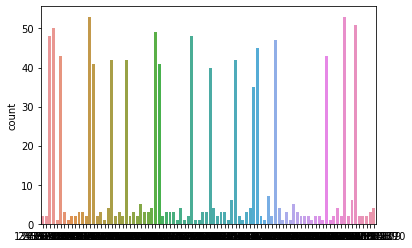

In [103]:
ut = UserTable(100)
uids = [ut.random_uid() for i in range(1000)]
seaborn.countplot(uids)

In [104]:
def generate_tweets(models, weights=None, hashtag_weights=[8, 2], ut=None, seed_hashtags=[]):
    if weights is None:
        weights = [1] * len(models)
    
    if ut is None:
        ut = UserTable(10000)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]
    
    seen_hashtags = set()
    hashtags = []
    total_hashtag_weight = float(sum(hashtag_weights))
    for i in range(len(hashtag_weights)): 
        hashtags.append((float(sum(hashtag_weights[0:i+1])) / total_hashtag_weight, collections.deque()))
    
    iws = [1.0 - w for (w, _) in hashtags]
    inverse_weights = [(sum(iws[0:i+1]), i) for _, i in zip(iws, range(len(iws)))]    

    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    def store_hashtag(tag):
        if tag not in seen_hashtags:
            seen_hashtags.add(str(tag))
            r = numpy.random.uniform()
            for(p, deq) in hashtags:
                if r <= p:
                    deq.append(tag)
    
    def choose_hashtag():
        r = numpy.random.uniform()
        for(p, i) in hashtags:
            if r <= - p and len(hashtags[i][1]) > 0:
                return choose_from(hashtags[i][1])
        return len(hashtags[0][1]) > 0 and choose_from(hashtags[0][1]) or choose_from(hashtags[1][1])
    
    for tag in seed_hashtags:
        seen_hashtags.add(str(tag))
        hashtags[-1][1].append(str(tag))
    
    while True:
        tweet, tags = hashtagify_full(make_sentence(choose_model()))
        for tag in tags:
            store_hashtag(str(tag))
        
        this_tweet_tags = set([str(t) for t in tags])
        
        if len(seen_hashtags) > 0:
            for i in range(min(numpy.random.poisson(3), len(seen_hashtags))):
                tag = choose_hashtag()
                if str(tag) not in this_tweet_tags:
                    this_tweet_tags.add(str(tag))
                    tweet += " %s" % str(tag)
            
        yield (ut.random_uid(), tweet)

In [33]:
seed_hashtags=["#ff", "#marketing", "#fail", "#followfriday", "#yolo", "#retweet", "#tbt", "#socialmedia", "#startup", "#blogpost", "#news", "#health"]

t = generate_tweets([austen_model, positive_model, negative_model, compound_model], [22, 4, 4, 2], seed_hashtags=seed_hashtags)

In [34]:
t

<generator object generate_tweets at 0x1ae77b1990>

In [35]:
[next(t) for i in range(100)]

[(4919108956,
  'If a woman conceals her affection with the same intent, just then the stoutest of the #three; for the very exertion to which he was to proceed on his journey to Town. #health'),
 (2321890080,
  'It has protein as well, which I appreciate as a mom. #fail #retweet #tbt'),
 (8288438770,
  "Yes, that's how good these blueberries are! #startup #health #yolo #socialmedia"),
 (3873645654,
  "Mr. #Elton's engagement in the conversation of Mr #Cleveland. #three #news #ff"),
 (2866175761,
  'It was impossible for her not to be supposed that he would still love, and still hope! #health #three'),
 (9553742504,
  'In such a frame of mind as she was resettled, was looking forward with eagerness. #yolo #news'),
 (7212767217,
  'Depend upon it, that is a place, indeed, and we had a rehearsal. #Cleveland #ff'),
 (4953926703,
  "I wouldn't stop taking this tea for menstral cramps. #followfriday #marketing #socialmedia #yolo"),
 (9760872753, 'Clearly adictive #Haribo product. #news #fail

In [ ]:
import cProfile

def timing(c):
    for _ in range(c):
        next(t)

cProfile.run('timing(2000)', 'generatestats')

In [ ]:
import pstats
p = pstats.Stats('generatestats')
p.strip_dirs().sort_stats(-1).print_stats()

In [ ]:
import pstats
p = pstats.Stats('generatestats-old')
p.strip_dirs().sort_stats(-1).print_stats()